In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.ioff()
figure(figsize=(10, 8), dpi=300)

<Figure size 3000x2400 with 0 Axes>

<Figure size 3000x2400 with 0 Axes>

In [2]:
job_arg = 8
# uncomment lines below to use CUDA
mne.utils.set_config('MNE_USE_CUDA', 'true')
job_arg = 'cuda'

# disable lines below to enable interactive plots
mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib')
mne.viz.set_browser_backend('matplotlib')

Using matplotlib as 2D backend.


In [3]:
# read mne-python format
raw = mne.io.read_raw_fif('../data_nn/ignore/grasp_a_5_raw.fif')
#raw_a = mne.io.read_raw_fif('../data/OBCI_16_raw.fif')
#raw = mne.io.concatenate_raws([raw_l, raw_a])
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)
raw.load_data()
raw.pick_types(emg=True, eeg=True, stim=True, exclude=[])


Opening raw data file ../data_nn/ignore/grasp_a_5_raw.fif...
Isotrak not found
    Range : 0 ... 960089 =      0.000 ...   960.089 secs
Ready.
Reading 0 ... 960089  =      0.000 ...   960.089 secs...


<Raw | grasp_a_5_raw.fif, 17 x 960090 (960.1 s), ~124.6 MB, data loaded>

Opening raw-browser...


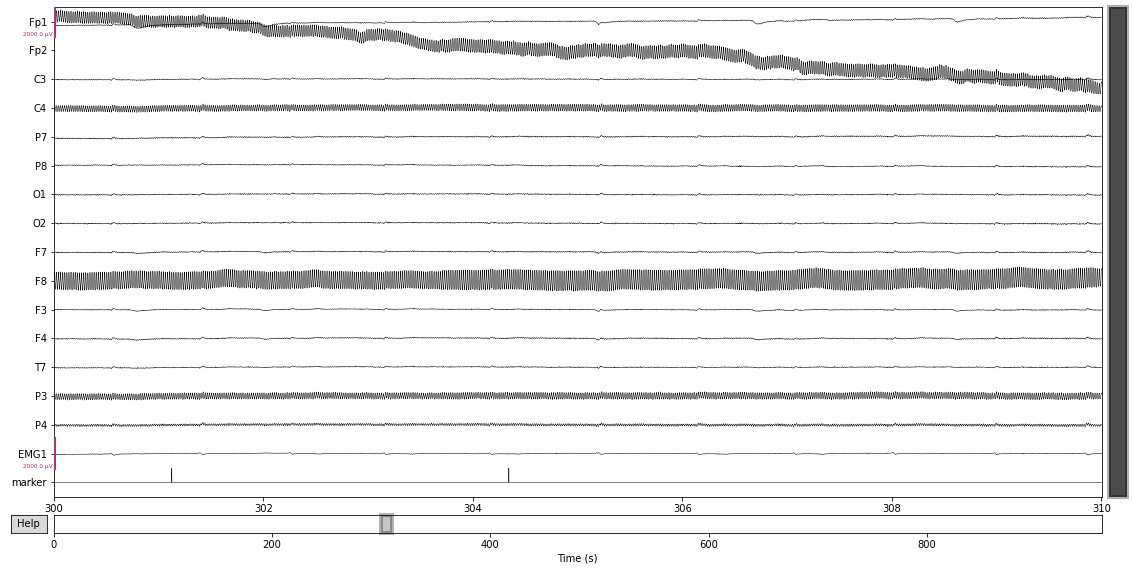

In [4]:

p = raw.plot(start = 300, duration = 10, scalings = dict(eeg = 10e-4), theme = 'dark')
# plt = raw.plot_psd(fmax=60.)
# plt = raw.plot_psd(fmax=60., average=True)
# plt = raw.plot_psd(fmin=90., fmax=500.0)
# plt = raw.plot_psd(fmin=90., fmax=500., average=True)

In [5]:
print(mne.get_config(key=''))

('MNE_3D_OPTION_ANTIALIAS', 'MNE_3D_OPTION_DEPTH_PEELING', 'MNE_3D_OPTION_SMOOTH_SHADING', 'MNE_3D_OPTION_THEME', 'MNE_BROWSE_RAW_SIZE', 'MNE_BROWSER_BACKEND', 'MNE_BROWSER_PRECOMPUTE', 'MNE_BROWSER_THEME', 'MNE_BROWSER_USE_OPENGL', 'MNE_CACHE_DIR', 'MNE_COREG_ADVANCED_RENDERING', 'MNE_COREG_COPY_ANNOT', 'MNE_COREG_GUESS_MRI_SUBJECT', 'MNE_COREG_HEAD_HIGH_RES', 'MNE_COREG_HEAD_OPACITY', 'MNE_COREG_HEAD_INSIDE', 'MNE_COREG_INTERACTION', 'MNE_COREG_MARK_INSIDE', 'MNE_COREG_PREPARE_BEM', 'MNE_COREG_ORIENT_TO_SURFACE', 'MNE_COREG_SCALE_LABELS', 'MNE_COREG_SCALE_BY_DISTANCE', 'MNE_COREG_SCENE_SCALE', 'MNE_COREG_WINDOW_HEIGHT', 'MNE_COREG_WINDOW_WIDTH', 'MNE_COREG_SUBJECTS_DIR', 'MNE_CUDA_DEVICE', 'MNE_CUDA_IGNORE_PRECISION', 'MNE_DATA', 'MNE_DATASETS_BRAINSTORM_PATH', 'MNE_DATASETS_EEGBCI_PATH', 'MNE_DATASETS_EPILEPSY_ECOG_PATH', 'MNE_DATASETS_HF_SEF_PATH', 'MNE_DATASETS_MEGSIM_PATH', 'MNE_DATASETS_MISC_PATH', 'MNE_DATASETS_MTRF_PATH', 'MNE_DATASETS_SAMPLE_PATH', 'MNE_DATASETS_SOMATO_PATH',

before doing the other method let's try a different way to detect / filter bad stuff

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Setting up band-pass filter from 8 - 32 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 32.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 36.00 Hz)
- Filter length: 1651 samples (1.651 sec)



C:\Users\webma\AppData\Local\Temp\ipykernel_4924\3482229208.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


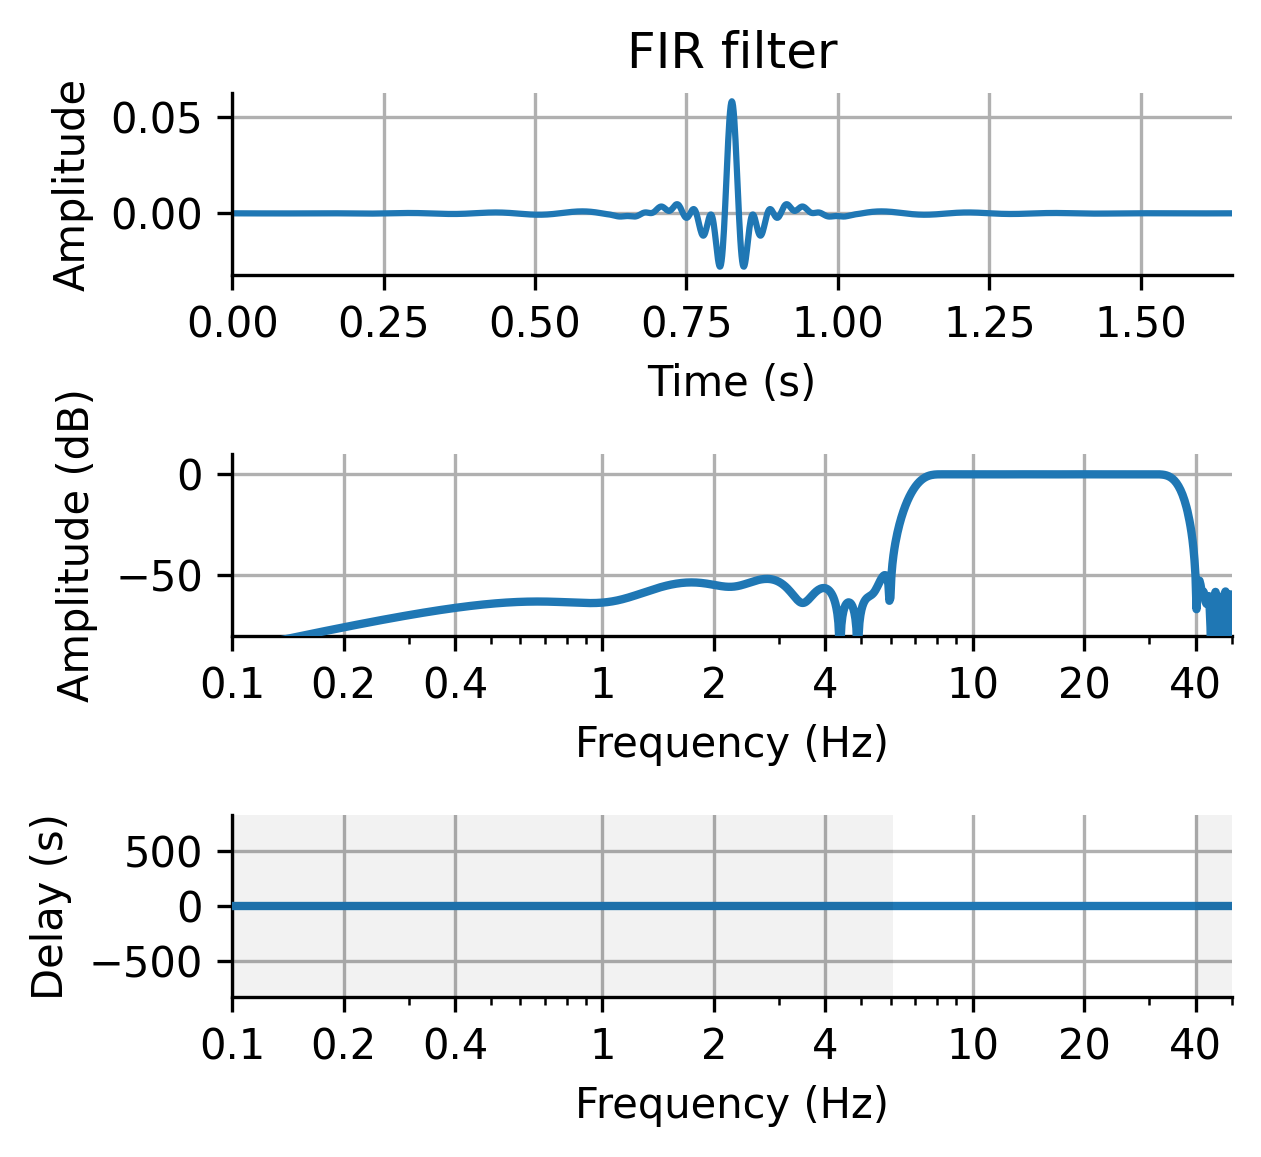

In [10]:

raw_avg_ref = raw.copy().set_eeg_reference(ref_channels='average')

filter_params = mne.filter.create_filter(raw_avg_ref.get_data(), raw_avg_ref.info['sfreq'],
                                         l_freq=8, h_freq=32)

fig = mne.viz.plot_filter(filter_params, raw_avg_ref.info['sfreq'], flim=(0.1, 50), show = False)
fig.set_figheight(4)
fig.set_figwidth(4)
fig.set_dpi(300)
fig.show()



Opening raw-browser...


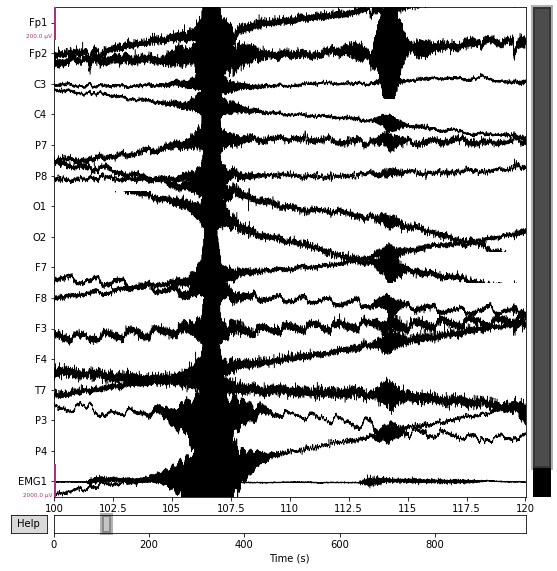

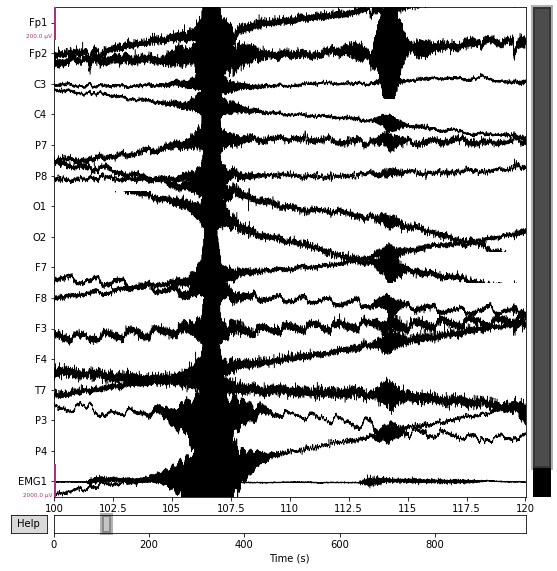

In [8]:
raw_notch.plot(n_channels = 16, start = 100, duration = 20, scalings = dict(eeg = 10e-5), theme = 'dark')

https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html
Best practices
To avoid the reduction in temporal precision of events that comes with resampling a Raw object, and also avoid the edge artifacts that come with filtering an Epochs or Evoked object, the best practice is to:

low-pass filter the Raw data at or below 
 
 of the desired sample rate, then

decimate the data after epoching, by either passing the decim parameter to the Epochs constructor, or using the decimate() method after the Epochs have been created.

Warning

The recommendation for setting the low-pass corner frequency at 
 
 of the desired sample rate is a fairly safe rule of thumb based on the default settings in raw.filter() (which are different from the filter settings used inside the raw.resample() method). If you use a customized lowpass filter (specifically, if your transition bandwidth is wider than 0.5× the lowpass cutoff), downsampling to 3× the lowpass cutoff may still not be enough to avoid aliasing, and MNE-Python will not warn you about it (because the raw.info object only keeps track of the lowpass cutoff, not the transition bandwidth). Conversely, if you use a steeper filter, the warning may be too sensitive. If you are unsure, plot the PSD of your filtered data before decimating and ensure that there is no content in the frequencies above the Nyquist frequency of the sample rate you’ll end up with after decimation.


while inspecting this waveform an idea came to me that it might be fun to try and make a point cloud out of the data, using coordinates eg sample sequence=time, channel = color, channel data / waveform = x,y,decim=z

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 33001 samples (33.001 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Opening raw-browser...


[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    1.1s finished


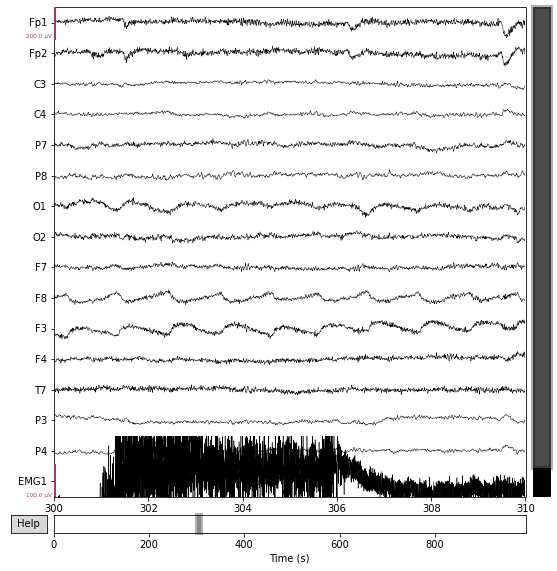

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_8768\2515742327.py:6: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=10 parameter will result in a sampling frequency of 100 Hz, which can cause aliasing artifacts.
  plt = raw_notch.plot(n_channels = 16, start = 300, duration = 10, scalings = scalings, theme = 'dark', decim=10)


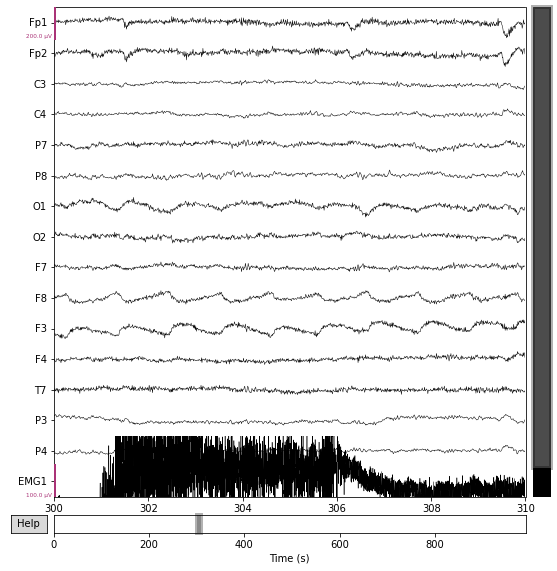

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_8768\2515742327.py:7: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=20 parameter will result in a sampling frequency of 50 Hz, which can cause aliasing artifacts.
  plt = raw_notch.plot(n_channels = 16, start = 300, duration = 10, scalings = scalings, theme = 'dark', decim=20)


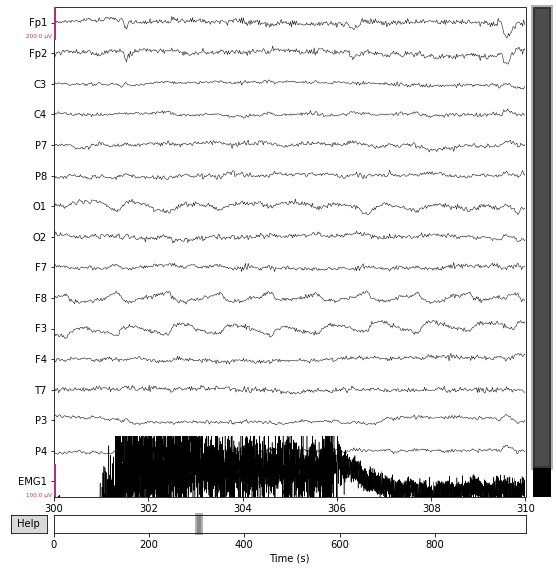

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_8768\2515742327.py:8: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=100 parameter will result in a sampling frequency of 10 Hz, which can cause aliasing artifacts.
  plt = raw_notch.plot(n_channels = 16, start = 300, duration = 10, scalings = scalings, theme = 'dark', decim=100)


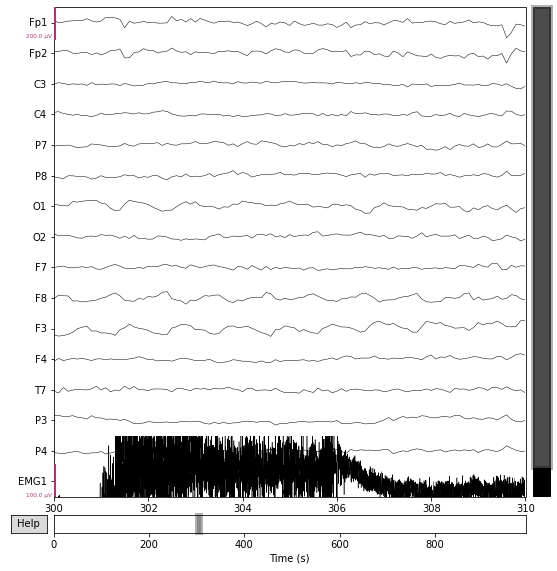

Opening raw-browser...


C:\Users\webma\AppData\Local\Temp\ipykernel_8768\2515742327.py:9: RuntimeWarning: The measurement information indicates a low-pass frequency of 49 Hz. The decim=1000 parameter will result in a sampling frequency of 1 Hz, which can cause aliasing artifacts.
  plt = raw_notch.plot(n_channels = 16, start = 300, duration = 10, scalings = scalings, theme = 'dark', decim=1000)


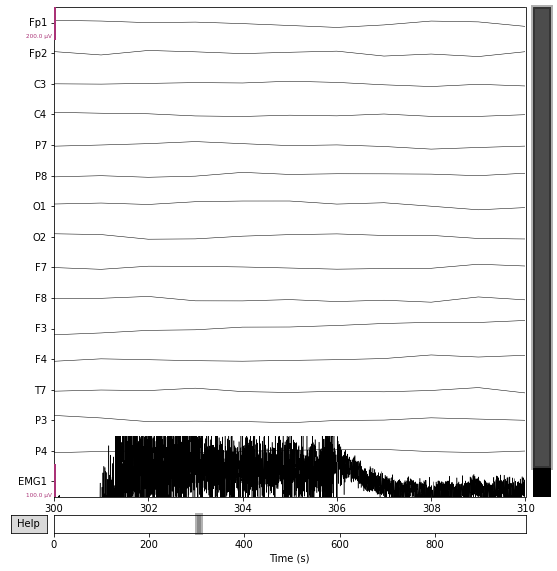

In [9]:
decim = 4
scalings = dict(eeg = 10e-5, emg = 5e-5)

raw_notch.filter(l_freq=0.1, h_freq=49., n_jobs=job_arg)
plt = raw_notch.plot(n_channels = 16, start = 300, duration = 10, scalings = scalings, theme = 'dark')
plt = raw_notch.plot(n_channels = 16, start = 300, duration = 10, scalings = scalings, theme = 'dark', decim=10)
plt = raw_notch.plot(n_channels = 16, start = 300, duration = 10, scalings = scalings, theme = 'dark', decim=20)
plt = raw_notch.plot(n_channels = 16, start = 300, duration = 10, scalings = scalings, theme = 'dark', decim=100)
plt = raw_notch.plot(n_channels = 16, start = 300, duration = 10, scalings = scalings, theme = 'dark', decim=1000)



In [10]:
# tbc...i think with a numpy array to 3d points, you could then just scale any axis, etc

In [11]:
events = mne.find_events(raw_notch)
reject = dict(eeg=150e-6)
epochs = mne.Epochs(raw_notch, events, event_id=event_ids, preload=True, reject=reject, tmin = -1, tmax=5, picks = ['C3', 'P3'])
# epochs = mne.Epochs(raw_notch, events, event_id=event_ids, preload=True)
epochs_ds = epochs.resample(sfreq=250., n_jobs=job_arg)


254 events found
Event IDs: [ 53 102 107 108 110 114]
Not setting metadata
253 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 253 events and 6001 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'P3']
    Rejecting  epoch based on EEG : ['C3', 'P3']
    Rejecting  epoch based on EEG : ['C3', 'P3']
    Rejecting  epoch based on EEG : ['C3', 'P3']
    Rejecting  epoch based on EEG : ['C3', 'P3']
    Rejecting  epoch based on EEG : ['C3', 'P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['C3', 'P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  ep

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 296 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 430 out of 430 | elapsed:    0.1s finished


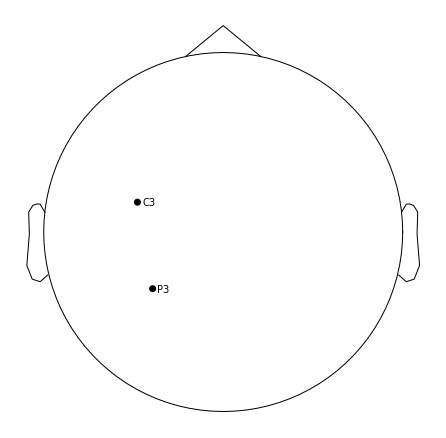

Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


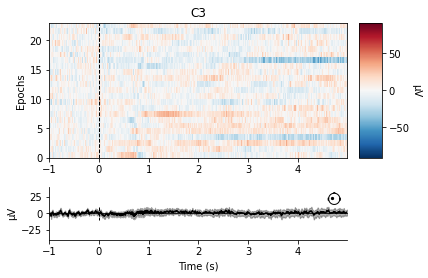

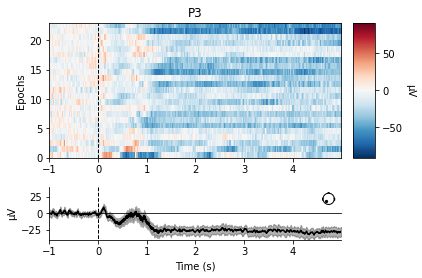

Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


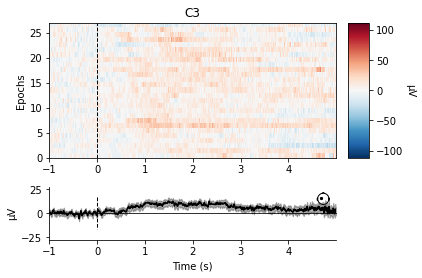

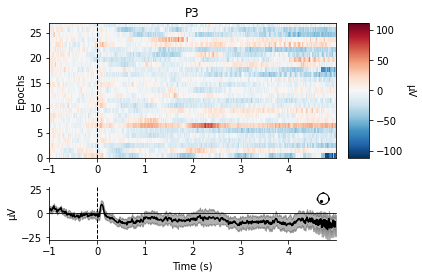

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


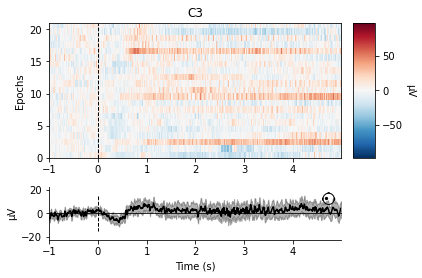

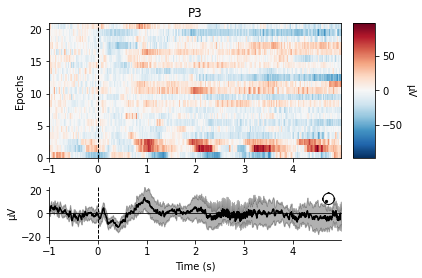

[<Figure size 432x288 with 4 Axes>, <Figure size 432x288 with 4 Axes>]

In [12]:
clench_epochs = epochs_ds['clench']
right_epochs = epochs_ds['right']

neutral_epochs = epochs_ds['neutral']

clench_epochs.plot_sensors(show_names=True)

clench_epochs.plot_image(picks=['C3', 'P3'])
right_epochs.plot_image(picks=['C3', 'P3'])
neutral_epochs.plot_image(picks=['C3', 'P3'])

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


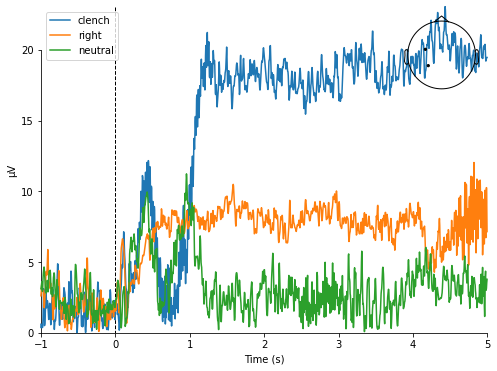

[<Figure size 576x432 with 2 Axes>]

In [13]:
clench_evoked = clench_epochs.average()
right_evoked = right_epochs.average()
neutral_evoked = neutral_epochs.average()

mne.viz.plot_compare_evokeds(dict(clench=clench_evoked, right=right_evoked, neutral=neutral_evoked), legend='upper left', show_sensors='upper right')

No projector specified for this dataset. Please consider the method self.add_proj.


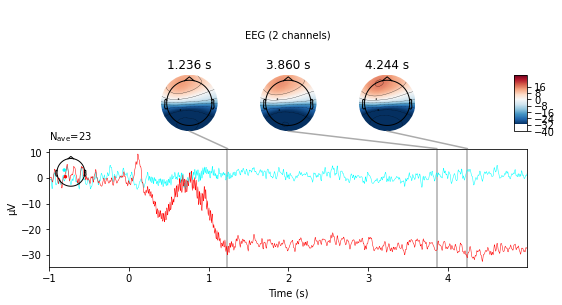

No projector specified for this dataset. Please consider the method self.add_proj.


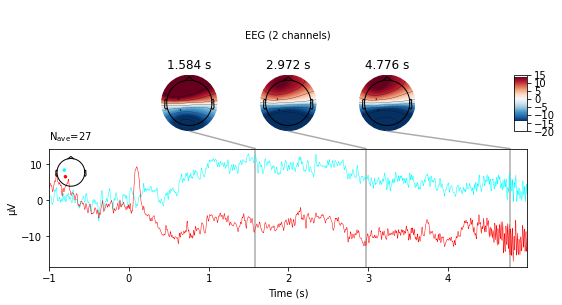

No projector specified for this dataset. Please consider the method self.add_proj.


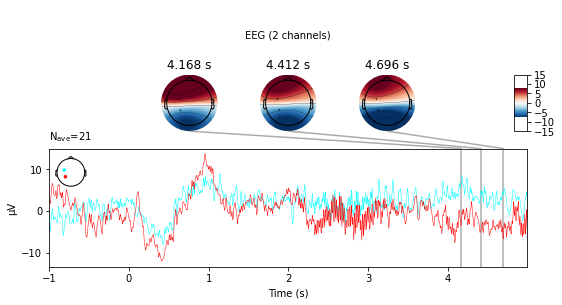

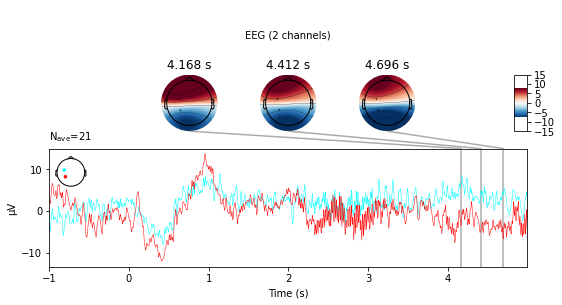

In [14]:
clench_evoked.plot_joint()
right_evoked.plot_joint()
neutral_evoked.plot_joint()